#Развертывание LLM


В командной строке пропишите:

curl -fsSL https://ollama.com/install.sh | sh

ollama serve &

ollama run gemma3:1b-it-q8_0

In [1]:
!pip install colab-xterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 4.4 MB/s eta 0:00:00


In [49]:
%load_ext colabxterm
%xterm

The colabxterm extension is already loaded. To reload it, use:
  %reload_ext colabxterm


Launching Xterm...

<IPython.core.display.Javascript object>

In [3]:
!pip install ollama

##Пример обращения к llm:

In [50]:
import ollama
model = 'gemma3:1b-it-q8_0'
prompt = 'Are u a reasoning model?'
response = ollama.chat(model=model, messages=[{'role':'user', 'content':prompt}])
print(response['message'])

role='assistant' content="Yes, absolutely! I am a reasoning model. \n\nHere’s a breakdown of what that means and how I work:\n\n**What is a Reasoning Model?**\n\n* **Focus on Logic and Inference:** My primary function is to analyze information and draw conclusions based on the facts presented. I’m designed to go beyond simple recall and understand the relationships between things.\n* **Pattern Recognition:** I’m trained on massive amounts of text data, allowing me to identify patterns and relationships that can be used to solve problems and make predictions.\n* **Logical Steps:** I can follow a series of logical steps (deductive reasoning, inductive reasoning, abductive reasoning) to arrive at answers or solutions.\n\n\n**How I Work (Simplified):**\n\n1. **Input:** You give me a question, problem, or statement.\n2. **Understanding:** I analyze your input to understand the meaning and context.\n3. **Reasoning:** I use my training data and logical processes to generate possible solutions

#Эксперименты с плохими функциями

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Функция создания prompt-а для LLM
def create_prompt(num_sol, df):
    meta_prompt_start = '''You will help me minimize a function with multiple variables.
                          I have some (w) pairs and the function values at those points.
                          The pairs are arranged in descending order based on their function values,
                          where lower values are better: \n'''
    solutions = ''
    if num_sol > len(df):
        num_sol = len(df)
    for i in range(num_sol):
        w_vector = df.w.iloc[-num_sol + i]
        weight_str = ', '.join([f'{num:.3f}' for num in w_vector])
        solutions += f'''w=[{weight_str}], loss_value={df.loss.iloc[-num_sol + i]:.3f}'''
    return meta_prompt_start + solutions


def goal_metric(loss_history):
    """
    Считает целевую метрику G_j по формуле
        G_j = 1/N * Σ_i ((loss_init - loss_i) / loss_init)
    """
    loss_init = loss_history[0]
    # относительное улучшение для каждого шага (включая 0‑й, где будет 0)
    improvements = [(loss_init - l) / loss_init for l in loss_history]
    return sum(improvements) / len(improvements)

def uncertainty_metric(loss_history):
    """
    Считает метрику U_j по формуле
        U_j = 1/N * Σ_i (loss_i − mean_loss)^2
    """
    mean_loss = sum(loss_history) / len(loss_history)
    sq_diffs = [(l - mean_loss) ** 2 for l in loss_history]
    return sum(sq_diffs) / len(sq_diffs)

# Функция, реализующая оптимизацию с помощью LLM.
# Сохраняем также каждое сгенерированное значение (вектор) в x_list для дальнейшей визуализации сходимости.
def run_optimization(function, dim, num_solutions, max_iter=100):
    # Начальное случайное решение
    w = np.random.uniform(-5, 5, dim)
    print('Starting with:', w)
    loss = function(w)

    # Создаем DataFrame для хранения истории: столбец "w" хранит список, представляющий вектор
    df = pd.DataFrame({'loss': [loss], 'w': [w.tolist()]})
    loss_list = [loss]
    x_list = [w.copy()]  # сохраняем вектор решения в каждом шаге
    i = 0
    while i < max_iter:
        system_prompt = create_prompt(num_solutions, df)

        prompt = f'''Give me a new w({dim} dimensional) that is different from all pairs above for at least 1e-6 for each cooordinate,
                and has a function value lower than any of the above.
                The output MUST CONTAIN ONLY a pair of numerical values for w
                in format "w = [w_1, w_2, w_3]" and NOTHING ELSE. Do not write code and repeat weights'''
        response = ollama.chat(model=model, messages=[{"role": "system", "content": system_prompt},{'role':'user', 'content':prompt}])
        output = response['message']['content']

        # Разбор вывода LLM
        try:
            if '[' in output and ']' in output:
              f_output = output[output.index('[')+1:output.index(']')]
            new_w = np.array([float(x.strip()) for x in f_output.split(',')])
        except Exception as e:
            print("Error parsing output:", output)
            max_iter += 1
            continue

        new_loss = function(new_w)

        # Добавляем новое решение в DataFrame и историю потерь.
        new_row = {'loss': new_loss, 'w': [new_w.tolist()]}  # оборачиваем список, чтобы сохранить в одной ячейке
        df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
        loss_list.append(new_loss)
        x_list.append(new_w.copy())

        # Сортируем DataFrame по значению loss (убывание – худшие решения в начале, лучшие в конце)
        df.sort_values(by='loss', ascending=False, inplace=True)
        if i % 25 == 0:
          print(f'Step {i}: Value={new_loss}')
        i += 1
    print(f'Final loss = {loss_list[-1]} with {x_list[-1]}')
    G = goal_metric(loss_list)
    print(f'Final Goal metric G = {G:.4f}')
    U = uncertainty_metric(loss_list)
    print(f'Final Uncertainty metric U = {U:.4f}')
    return df, loss_list, x_list, G, U

In [12]:
# Функция для построения графиков сходимости:
# 1) по норме разницы между значением функции и оптимальным значением (f* = 0)
# 2) по норме разницы между аргументом и оптимальным аргументом (оптимум – вектор 0)
def plot_results(loss_list, x_gap, function_name, min=0):
    iterations = np.arange(len(loss_list))

    f_gap = [abs(loss) for loss in loss_list]
    x_gap = [np.linalg.norm(x) for x in x_gap]

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].plot(iterations, f_gap, marker='o', label='|f(x)-f*|')
    axs[0].set_yscale('log')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Function gap')
    axs[0].set_title(f'Convergence by function value gap ({function_name})')
    axs[0].grid(True, which="both", linestyle=":")
    axs[0].legend()

    axs[1].plot(iterations, x_gap, marker='o', label='||x-x*||')
    axs[1].set_yscale('log')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Argument gap')
    axs[1].set_title('Convergence by argument gap')
    axs[1].grid(True, which="both", linestyle=":")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

#Эксперименты

In [7]:
def rastrigin(w):
    """Rastrigin function"""
    return 10 * len(w) + sum([(xi**2 - 10 * np.cos(2 * np.pi * xi)) for xi in w])

**Усреднение без сдвига. Функция Растрыгина. dim=3, num_solutions=50, max_iter=200**

Experiment 1 started...
Shift: 0
Starting with: [-3.21729463 -1.60372777 -3.33784916]
Step 0: Value=39.322511297764976
Step 25: Value=2.7774885964504392e-05
Step 50: Value=2.7774885964504392e-05
Step 75: Value=2.777490237804159e-09
Final loss = 2.7774885964504392e-05 with [0.0001 0.0002 0.0003]
Final Goal metric G = 0.9820
Final Uncertainty metric U = 57.9824


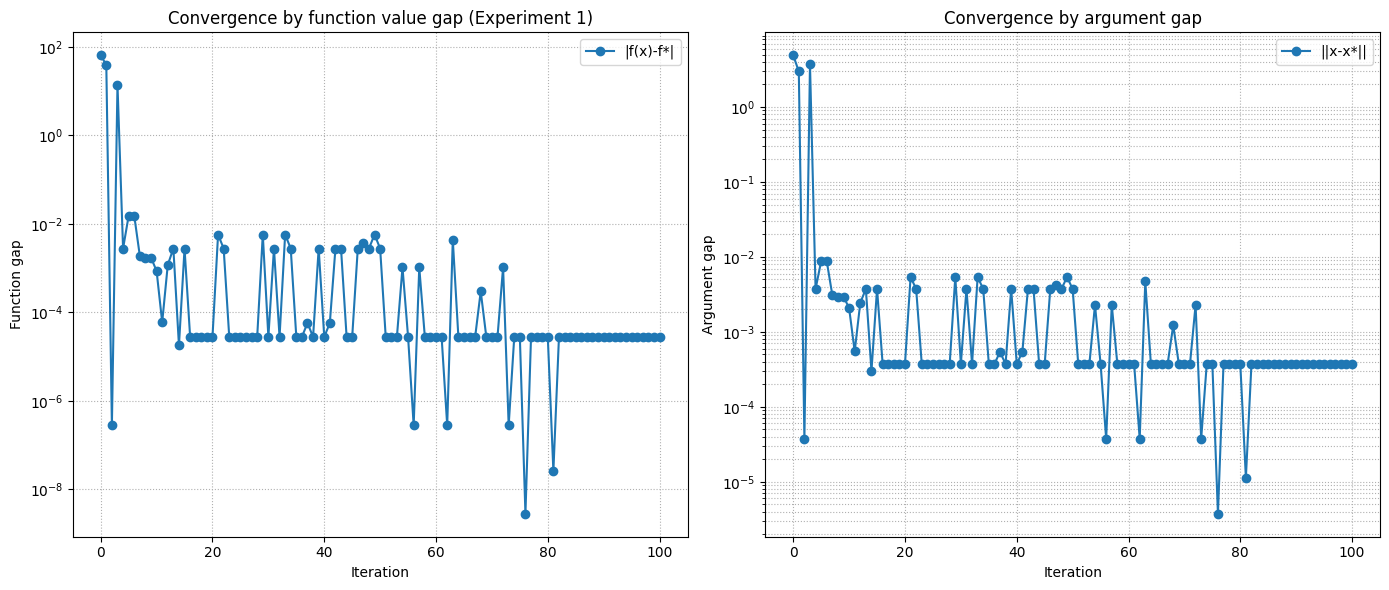

Experiment 2 started...
Shift: 0
Starting with: [1.32926653 4.99569869 2.35019914]
Step 0: Value=32.500000000000014
Step 25: Value=3.0
Step 50: Value=44.432270809007434
Step 75: Value=3.014777425592378
Final loss = 3.014777425592378 with [1.001 1.002 1.003]
Final Goal metric G = 0.8684
Final Uncertainty metric U = 169.5805


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (101,) + inhomogeneous part.

In [52]:
import scipy
N_EXP = 5
loss_lists = []
x_lists = []
goal_metrics = []
uncertainty_metrics = []
for N in range(N_EXP):
  print(f'Experiment {N+1} started...')
  shift = 0
  print('Shift:', shift)
  df, loss_list, x_list, G_metric, U_metric = run_optimization(lambda x: rastrigin(x+shift), dim=3, num_solutions=50, max_iter=100)
  loss_lists.append(loss_list)
  x_lists.append(np.linalg.norm(x_list, axis=1))
  goal_metrics.append(G_metric)
  uncertainty_metrics.append(U_metric)
  plot_results(loss_list, x_list, f'Experiment {N+1}', min=-shift)
harm_avg_loss_list = scipy.stats.hmean(np.array(loss_lists), axis=0)
avg_loss_list = np.mean(np.array(loss_lists), axis=0)
harm_avg_x_list = scipy.stats.hmean(x_lists, axis=0)
plot_results(harm_avg_loss_list, harm_avg_x_list, "harm_avg, gemma3:1b", min=-shift)
print(f'FINAL loss: harm. mean:{harm_avg_loss_list[-1]}, mean{avg_loss_list[-1]}, avg goal metric:{np.mean(np.array(goal_metrics))}, avg uncertainty metric:{np.mean(np.array(uncertainty_metrics))}')

##Другие функции

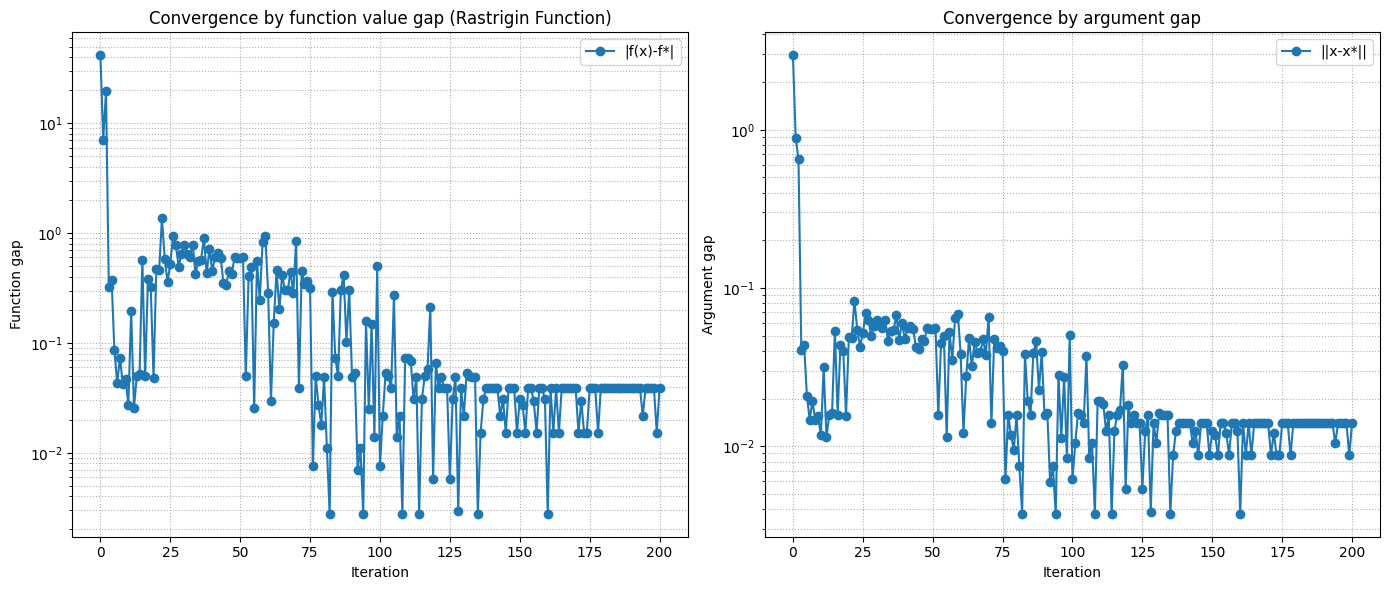

In [ ]:
def rastrigin(w):
    """Rastrigin function"""
    return 10 * len(w) + sum([(xi**2 - 10 * np.cos(2 * np.pi * xi)) for xi in w])

df, loss_list, x_list = run_optimization(rastrigin, dim=3, num_solutions=50, max_iter=200)

plot_results(loss_list, x_list, "Rastrigin Function")

In [ ]:
import numpy as np

def ackley(w, a=20, b=0.2, c=2*np.pi):
    """Ackley function"""
    n = len(w)
    sum_sq = sum(xi**2 for xi in w)
    sum_cos = sum(np.cos(c*xi) for xi in w)
    return -a * np.exp(-b * np.sqrt(sum_sq / n)) \
           - np.exp(sum_cos / n) + a + np.e

def griewank(w):
    """Griewank function"""
    part1 = sum(xi**2 for xi in w) / 4000
    part2 = np.prod([np.cos(xi / np.sqrt(i + 1)) for i, xi in enumerate(w)])
    return part1 - part2 + 1

def levy(w):
    """Levy function"""
    w_ = [1 + (xi - 1) / 4 for xi in w]
    term1 = np.sin(np.pi * w_[0])**2
    term2 = sum(
        (w_[i] - 1)**2 * (1 + 10 * np.sin(np.pi * w_[i] + 1)**2)
        for i in range(len(w) - 1)
    )
    term3 = (w_[-1] - 1)**2 * (1 + np.sin(2 * np.pi * w_[-1])**2)
    return term1 + term2 + term3

def sphere(w):
    """Sphere function (sum of squares)"""
    return sum(xi**2 for xi in w)

def rosenbrock(w):
    """Rosenbrock function"""
    return sum(
        100 * (w[i+1] - w[i]**2)**2 + (w[i] - 1)**2
        for i in range(len(w) - 1)
    )

def rastrigin(w):
    """Rastrigin function"""
    return 10 * len(w) + sum([(xi**2 - 10 * np.cos(2 * np.pi * xi)) for xi in w])

functions = [ackley, griewank, levy, sphere, rosenbrock, rastrigin]

[19.13369643  6.74303267 -7.51684403]
[1.04142478 1.09509253 2.76962893]


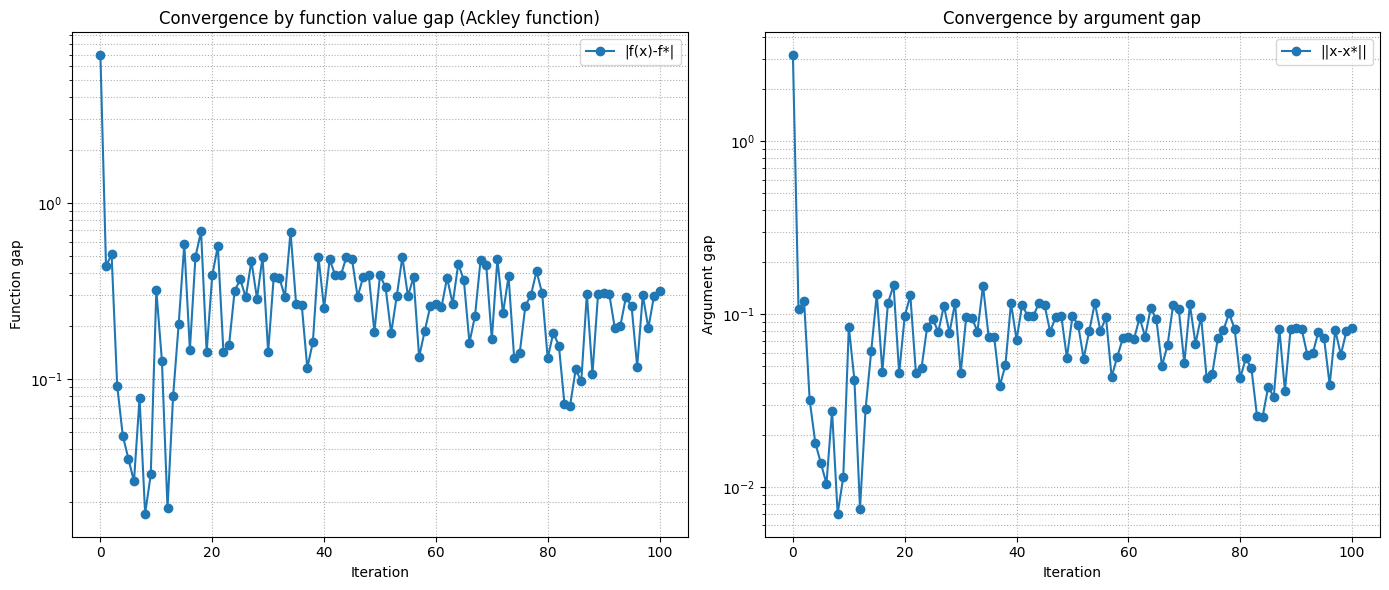

[  2.65810779  13.4369303  -14.80014344]
[ 4.05000259 -4.15648298 -4.54490497]


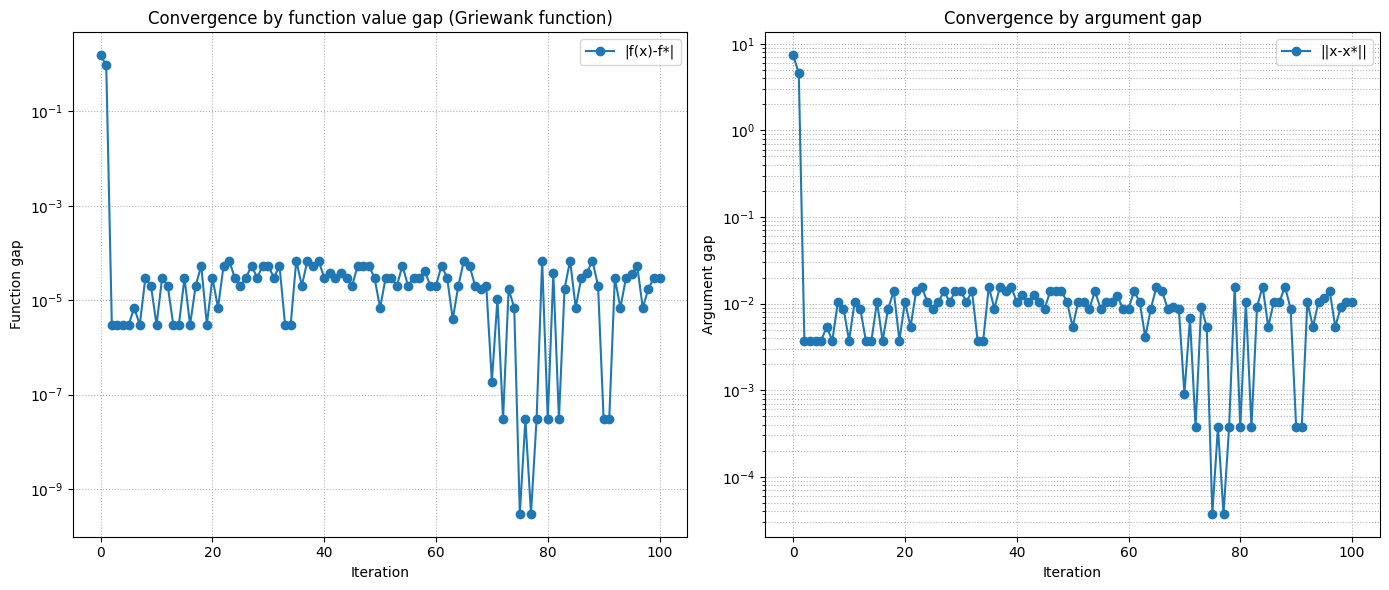

[14.91875094 -1.52292372 -0.9778275 ]
[4.44320786 3.06499106 3.12201581]


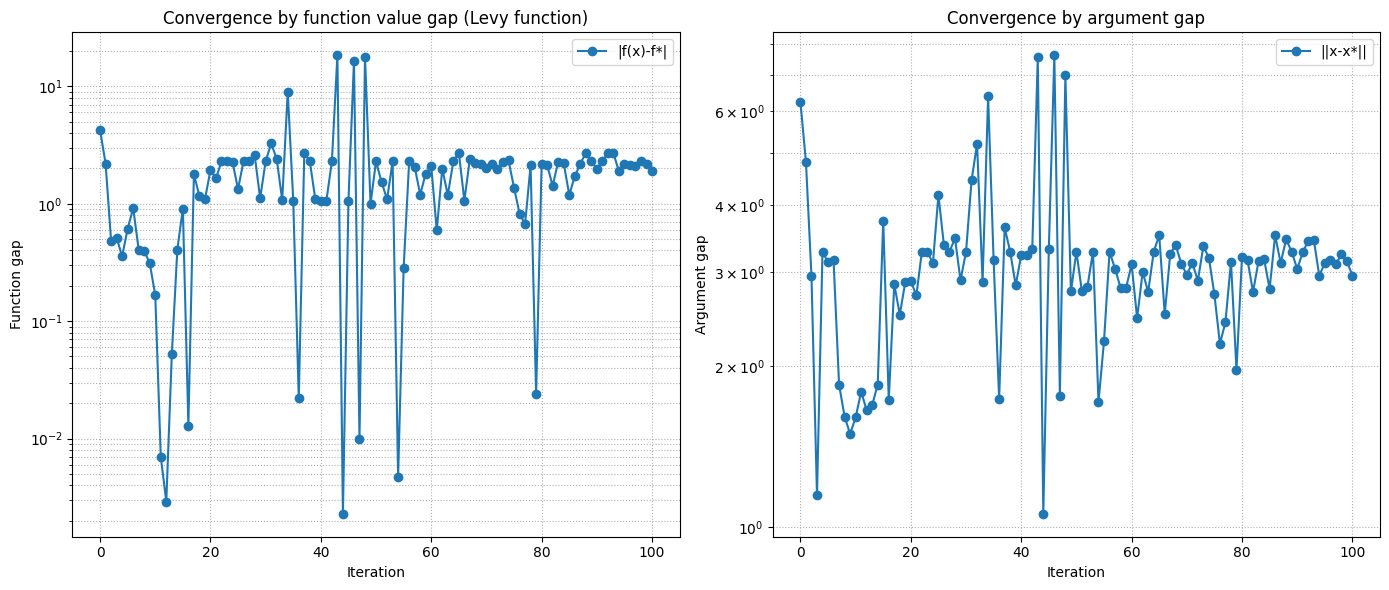

[18.98747346  1.82778672 -1.18030928]
[ 4.3686515   0.38706231 -4.18395452]


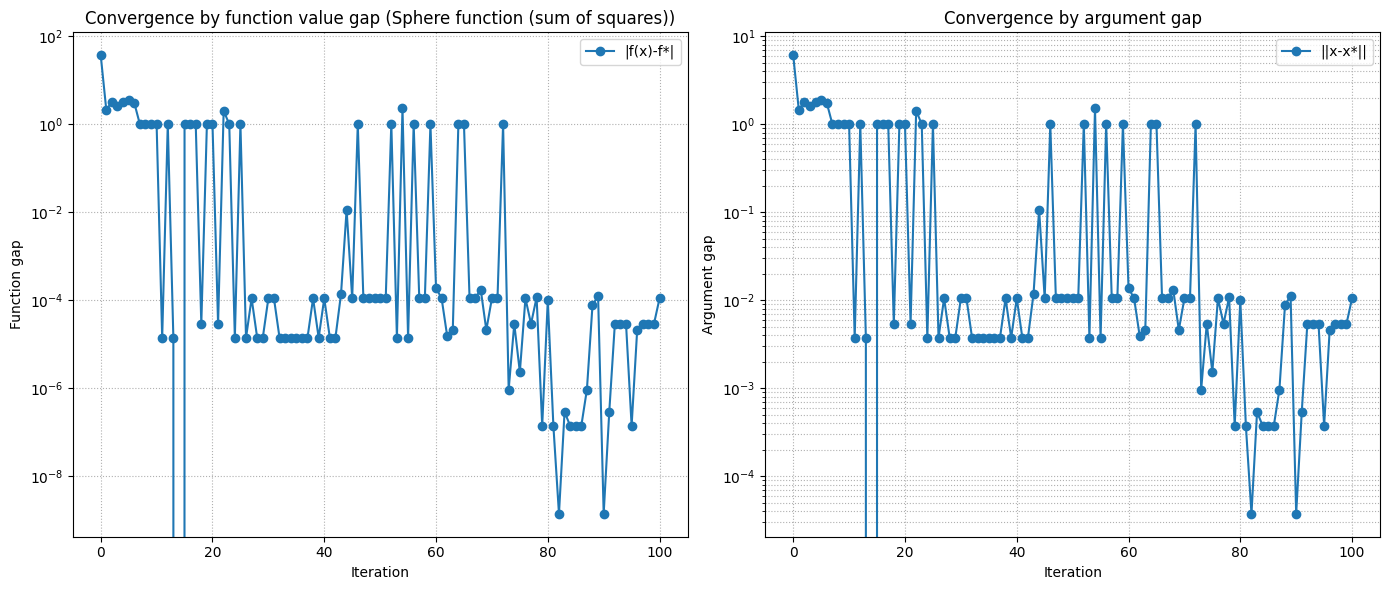

[ 12.13869816 -10.15552819  -9.16164843]
[-1.20684574  2.5917244  -0.6712348 ]


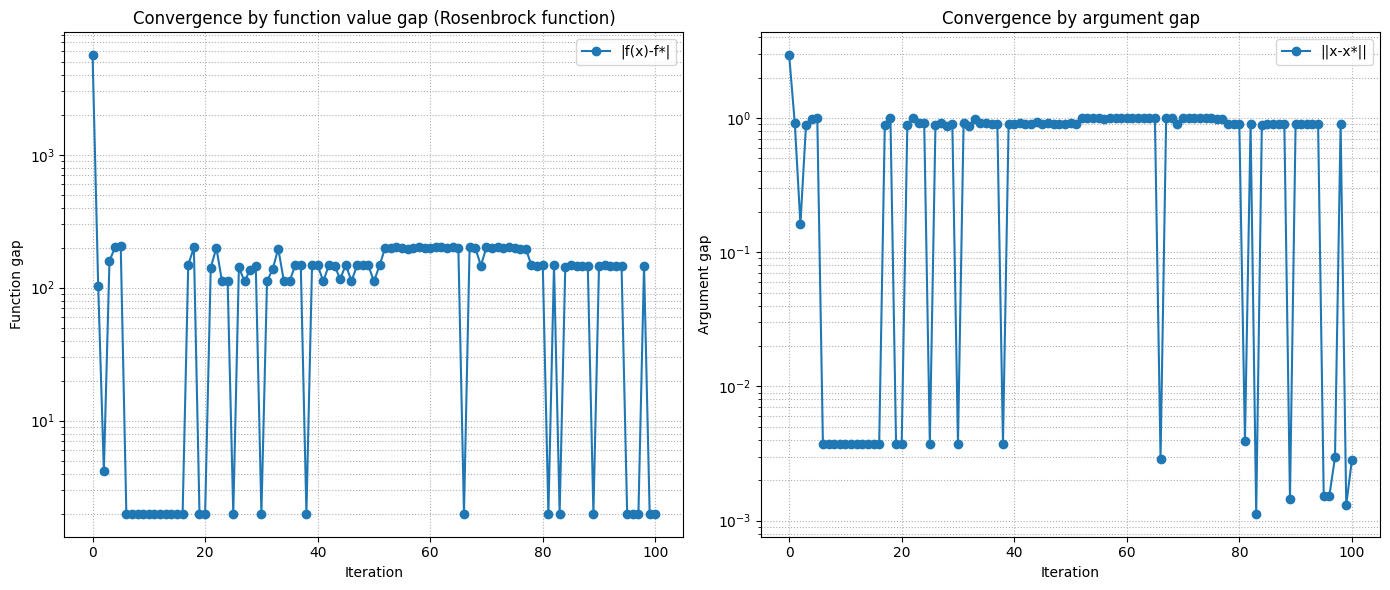

[ -8.05844728   1.16710372 -18.32285192]
[-1.67348634  2.63880897  3.28560295]


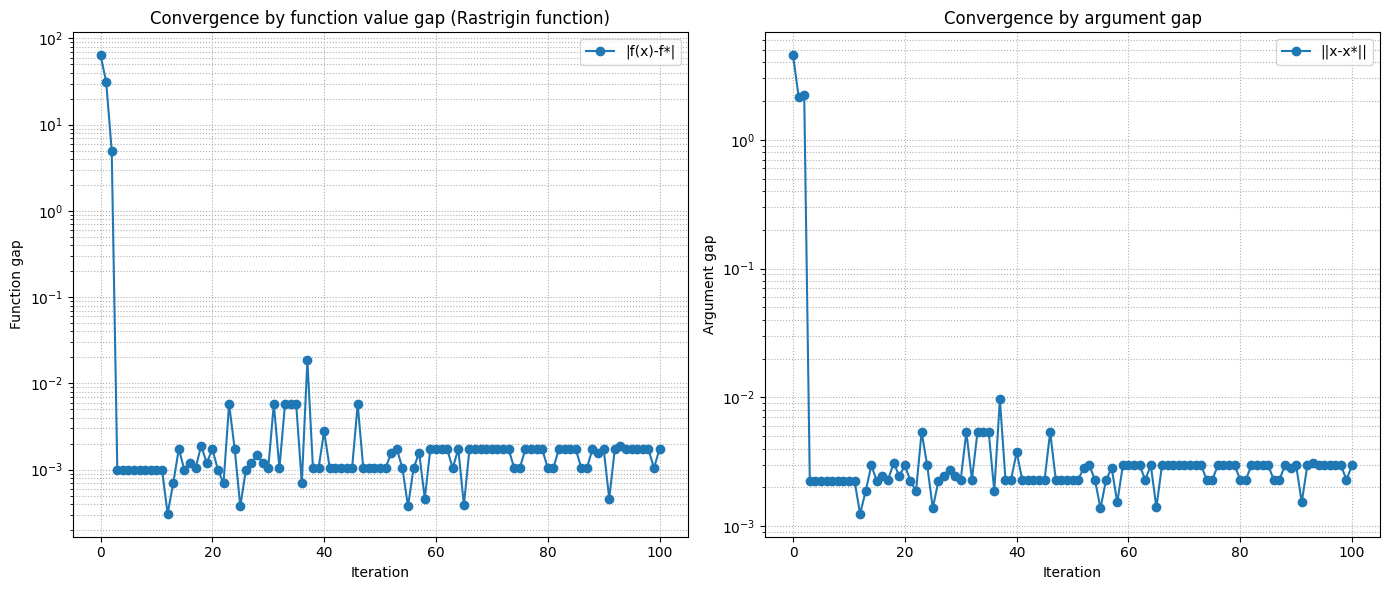

In [ ]:
for function in functions:
  dim = 3
  num_solutions = 50
  max_iter = 100
  df, loss_list, x_list = run_optimization(function, dim=dim, num_solutions=num_solutions, max_iter=max_iter)
  plot_results(loss_list, x_list, function.__doc__)


[-2.76223391 -0.81850991 -4.71965931]
[1.53154902 1.99533517 2.87016686]
w = [1.0, 1.1, 1.2]
Step 0: Value=56.69428755900066
w = [1.0, 1.1, 1.2]
w = [1.000, 1.100, 1.200]
w = [1.000, 1.100, 1.200]
w = [1.000, 1.001, 1.002]
w = [1.001, 1.002, 1.003]
w = [1.001, 1.002, 1.003]
w = [1.001, 1.002, 1.003]
w = [1.001, 1.002, 1.003]
w = [1.001, 1.002, 1.003]
w = [1.001, 1.002, 1.003]
w = [1.001, 1.002, 1.003]
w = [1.001, 1.002, 1.003]
w = [1.001, 1.002, 1.003]
w = [1.0, 2.0, 3.0]
w = [1.0, 2.0, 3.0]
w = [1.001, 1.002, 1.003]
w = [1.001, 1.002, 1.003]
w = [1.001, 1.002, 1.003]
w = [1.001, 1.002, 2.000]
w = [1.0, 2.0, 3.0]
w = [1.0, 2.0, 3.0]
w = [1.001, 1.002, 2.000]
w = [1.001, 1.002, 2.000]
w = [1.0, 2.0, 3.0]
w = [1.0, 2.0, 3.0]
w = [1.000, 1.100, 1.200]
w = [1.001, 1.002, 2.000]
w = [1.01, 1.02, 1.03]
w = [1.001, 1.002, 1.003]
w = [1.015, 1.005, 1.003]
w = [1.001, 1.002, 2.000]
w = [1.001, 1.002, 2.000]
w = [1.001, 1.002, 1.003]
w = [1.010, 1.001, 1.002]
w = [1.015, 1.003, 1.002]
w = [1.001

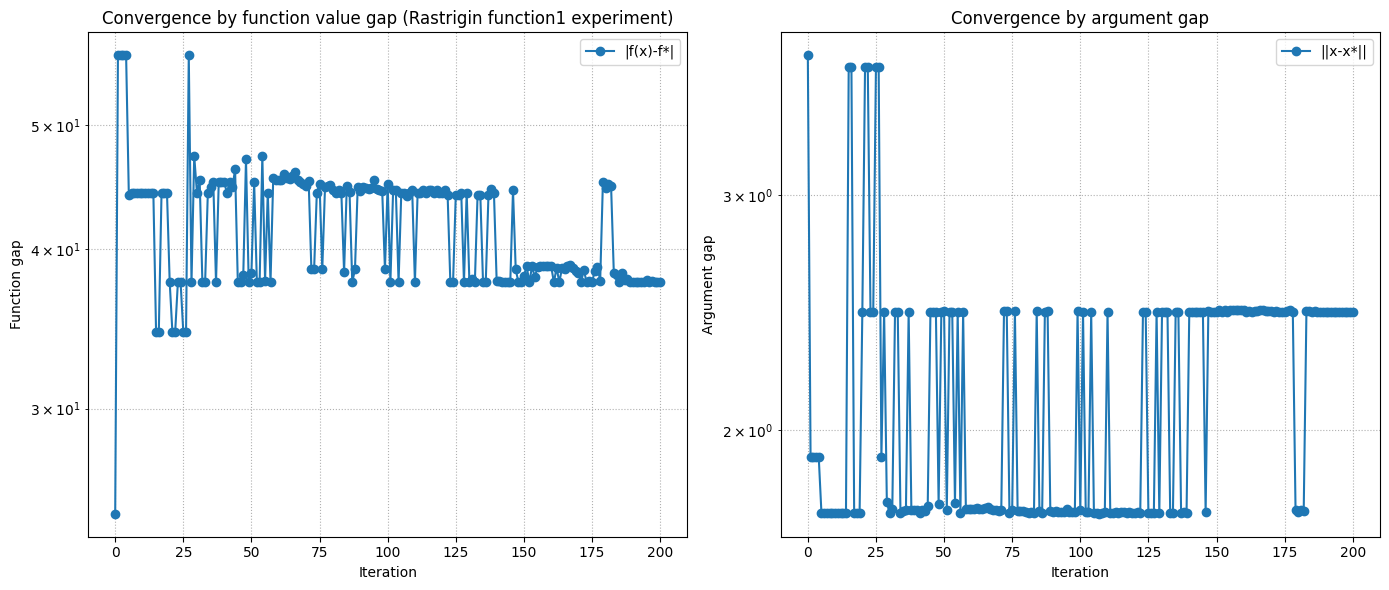

[-2.44085186  1.89992991  4.31731436]
[ 4.42623834 -0.28774746  1.68793   ]
w = [0.001, 0.002, 0.003]
Step 0: Value=63.64447319145225
w = [0.0005, 0.0015, 0.0025]
w = [0.0005, 0.0011, 0.0020]
w = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006]
Error parsing output: .0003, 0.0004, 0.0005, 0.0006]
w = [0.0002, 0.0003, 0.0004]
w = [0.0005, 0.0010, 0.0008]
w = [0.0005, 0.001, 0.002]
w = [0.0001, 0.001, 0.002]
w = [0.0001, 0.0002, 0.0003]
w = [0.0000000000000000000000000000000
w = [0.0001, 0.0002, 0.0003]
w = [0.0005, 0.0010, 0.0008]
w = [0.0002, 0.0008, 0.0011]
w = [0.0002, 0.0003, 0.0004]
w = [0.0005, 0.001, 0.002]
w = [0.0005, 0.0005, 0.0005]
w = [0.0001, 0.001, 0.002]
w = [0.0005, 0.001, 0.002]
w = [0.0001, 0.0002, 0.0003]
w = [0.0001, 0.001, 0.002]
w = [0.001, 0.002, 0.003]
w = [0.0008, 0.0012, 0.0023]
w = [0.0005, 0.0011, 0.0022]
w = [0.0002, 0.0013, 0.0027]
w = [0.001, 0.002, 0.003]
w = [0.001, 0.002, 0.003]
w = [0.001, 0.002, 0.003]
w = [0.001, 0.002, 0.003]
w = [0.002, 0.003, 0.00

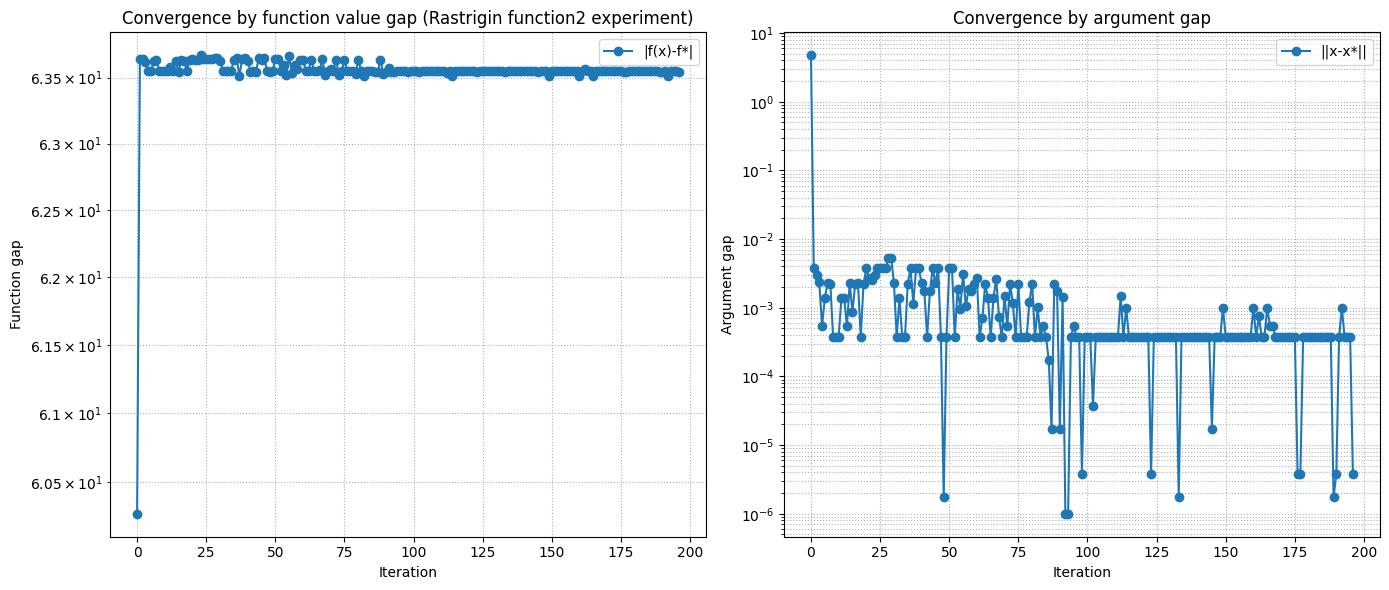

[-3.97025252  1.50838818  1.93257669]
[4.73531876 4.68234473 4.88103584]
w = [4.558, 4.623, 4.759]
Step 0: Value=118.04216112998594
w = [4.57, 4.61, 4.58]
w = [4.590, 4.575, 4.585]
w = [4.622, 4.635, 4.617]
w = [4.748, 4.750, 4.749]
w = [4.650, 4.630, 4.620]
w = [4.760, 4.750, 4.748]
w = [4.585, 4.605, 4.595]
w = [4.770, 4.760, 4.750]
w = [4.675, 4.623, 4.598]
w = [4.765, 4.755, 4.745]
w = [4.683, 4.679, 4.676]
w = [4.775, 4.760, 4.755]
w = [4.778, 4.769, 4.765]
w = [4.772, 4.773, 4.774]
w = [4.785, 4.770, 4.765]
w = [4.789, 4.778, 4.775]
w = [4.768, 4.771, 4.769]
w = [4.768, 4.769, 4.770]
w = [4.787, 4.786, 4.785]
w = [4.795, 4.788, 4.787]
w = [4.787, 4.786, 4.785]
w = [4.779, 4.778, 4.777]
w = [4.645, 4.648, 4.646]
w = [4.778, 4.777, 4.776]
w = [4.805, 4.798, 4.796]
w = [4.652, 4.647, 4.653]
w = [4.658, 4.673, 4.676]
w = [1.0, 2.0, 3.0]
w = [1.000, 2.000, 3.000]
w = [1.000, 2.000, 3.000]
w = [1.000, 2.000, 3.000]
w = [1.0, 2.0, 3.0]
w = [1.000, 2.000, 3.000]
w = [1.0, 2.0, 3.0]
w = [

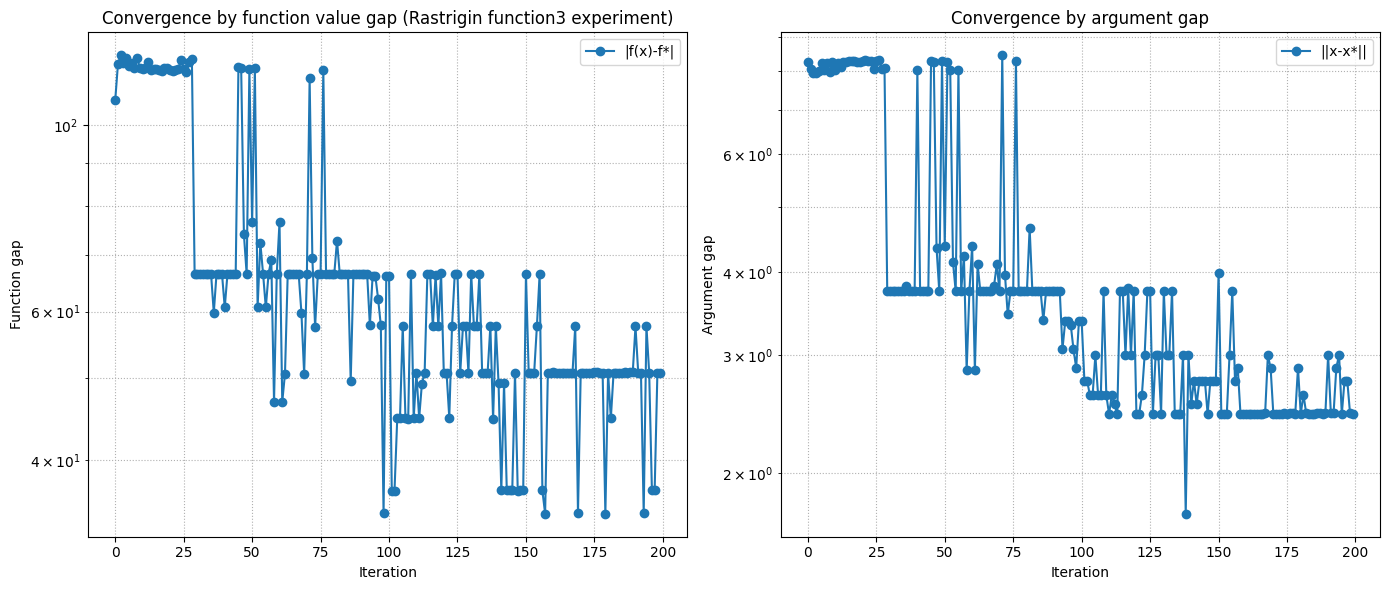

[-4.41575212 -0.85740957 -1.03385091]
[-2.00908977  2.8317887  -2.0919316 ]
w = [1.234, 3.567, -0.890]
Step 0: Value=40.64346447939108
w = [1.001, 2.002, -1.003]
w = [0.123, 0.987, -0.456]
w = [0.001, 0.002, 0.003]
w = [0.001, 0.002, 0.003]
w = [0.002, 0.003, 0.004]
w = [0.0012, 0.0023, 0.0034]
w = [0.0001, 0.0002, 0.0003]
w = [0.001, 0.002, 0.003]
w = [0.001, 0.002, 0.003]
w = [0.001, 0.002, 0.003]
w = [0.001, 0.002, 0.003]
w = [0.002, 0.003, 0.004]
w = [0.0001, 0.0002, 0.0003]
w = [0.001, 0.002, 0.003]
w = [0.001, 0.002, 0.003]
w = [0.001, 0.002, 0.003]
w = [0.0005, 0.0003, 0.0002]
w = [0.001, 0.002, 0.003]
w = [0.0002, 0.0003, 0.0004]
w = [0.002, 0.003, 0.004]
w = [0.0001, 0.0002, 0.0003]
w = [0.0008, 0.0011, 0.0020]
w = [0.001, 0.002, 0.003]
w = [0.0008, 0.0011, 0.0024]
w = [0.0008, 0.0012, 0.0025]
w = [0.000001, 0.000002, 0.000003]
w = [0.001, 0.002, 0.003]
w = [0.001, 0.002, 0.003]
w = [0.001, 0.002, 0.003]
w = [0.001, 0.002, 0.003]
w = [0.001, 0.002, 0.003]
w = [0.002, 0.003, 0.

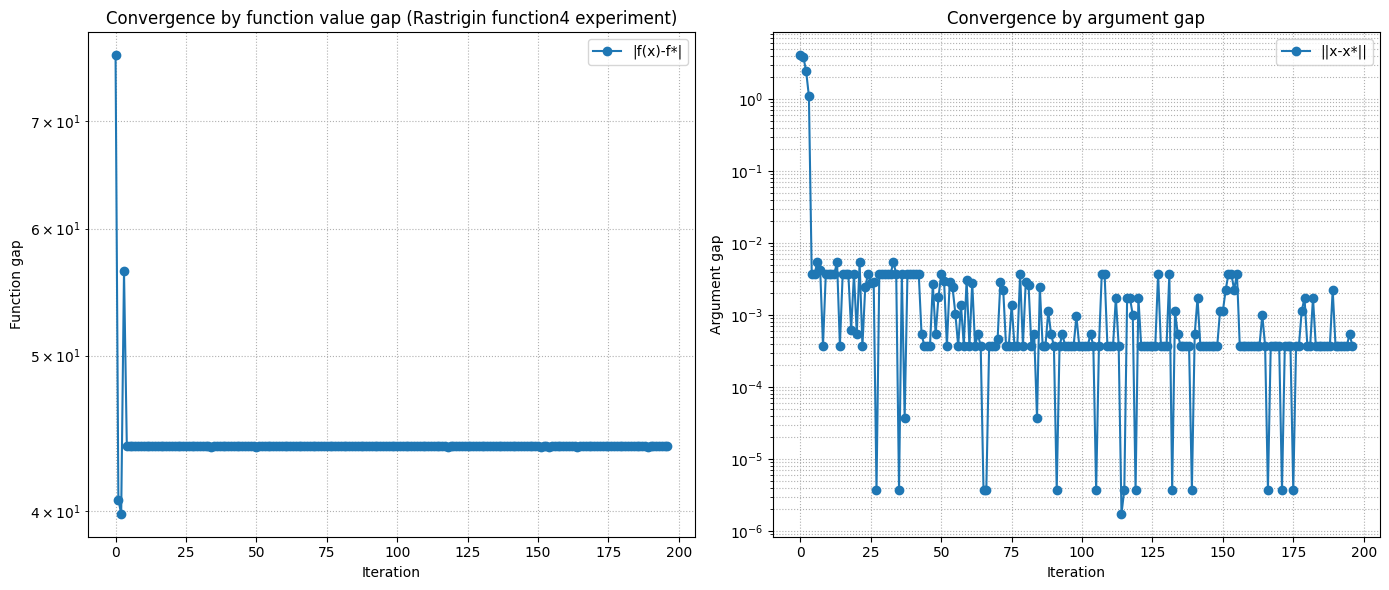

[-3.78930526  1.61939955 -3.4940305 ]
[ 3.26591054 -3.07285832  3.25716203]
w = [1.0, 2.5, 3.1]
Step 0: Value=53.008949429237745
w = [1.0000000000000002, -1.000000000000001, 0.9999999999999999]
Error parsing output: 000000001, 0.9999999999999999]
w = [1.000, 2.500, 3.266]
w = [1.0000000000000001, 2.5000000000000001, 3.2666666666666666]
Error parsing output: 000000001, 3.2666666666666666]
w = [1.000, 2.500, 3.100]
w = [1.000, 2.500, 3.100]
w = [1.000, 2.500, -3.073]
w = [1.0000000000000001, 2.5000000000000001, -3.0730000000000001]
Error parsing output: 00000001, -3.0730000000000001]
w = [1.000, 2.500, -3.073]
w = [1.000, 2.500, 3.266]
w = [1.000, 2.500, -3.073]
w = [1.000, 2.500, 3.266]
w = [1.000, 2.500, 3.266]
w = [1.000, 2.500, -3.073]
w = [1.000, 2.500, 3.100]
w = [1.000, 2.500, 3.266]
w = [1.000, 2.500, 3.100]
w = [1.0, 2.0, 3.0]
w = [1.001, 2.002, 3.003]
w = [1.000, 2.000, 3.000]
w = [1.001, 2.500, 3.266]
w = [1.001, 2.000, 3.000]
w = [1.000, 2.000, 3.000]
w = [1.001, 2.500, 3.266

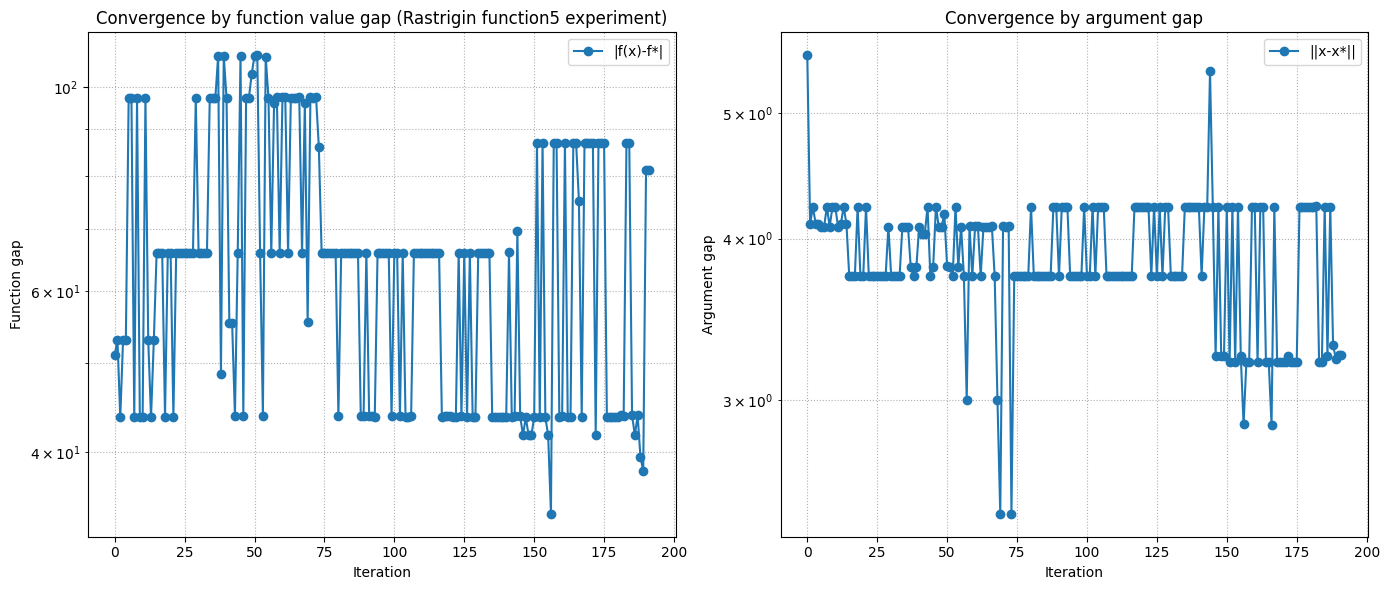

AttributeError: 'list' object has no attribute 'mean'

In [ ]:
NUM_EXP = 5
function = rastrigin
dim = 3
num_solutions = 50
max_iter = 200
avg_loss = []
avg_x = []
for N in range(NUM_EXP):
  # у всех функций минимум в 0 равный 0, для чистоты эксперимента генерирую сдвиг аргумента
  shift = np.random.uniform(-5, 5, dim)
  print(shift)
  df, loss_list, x_list = run_optimization(lambda x: function(x+shift), dim=dim, num_solutions=num_solutions, max_iter=max_iter)
  avg_loss.append(loss_list)
  avg_x.append(x_list)
  plot_results(loss_list, x_list+shift, function.__doc__ + f'{N + 1} experiment')

avg_loss = avg_loss.mean(axis=0)
avg_x = avg_x.mean(axis=0)
plot_results(avg_loss, avg_x+shift, function.__doc__)


In [ ]:
plot_results(avg_loss, avg_x+shift, function.__doc__)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

#Эксперименты с хорошими функциями большой размерности


In [ ]:
import scipy
N_EXP = 5
loss_lists = []
x_lists = []
goal_metrics = []
uncertainty_metrics = []
for N in range(N_EXP):
  print(f'Experiment {N+1} started...')
  shift = 0
  print('Shift:', shift)
  df, loss_list, x_list, G_metric, U_metric = run_optimization(lambda x: rastrigin(x+shift), dim=3, num_solutions=50, max_iter=10)
  loss_lists.append(loss_list)
  x_lists.append(np.linalg.norm(x_list, axis=1))
  goal_metrics.append(G_metric)
  uncertainty_metrics.append(U_metric)
  plot_results(loss_list, x_list, f'Experiment {N+1}', min=-shift)
harm_avg_loss_list = scipy.stats.hmean(np.array(loss_lists), axis=0)
avg_loss_list = np.mean(np.array(loss_lists), axis=0)
harm_avg_x_list = scipy.stats.hmean(x_lists, axis=0)
plot_results(harm_avg_loss_list, harm_avg_x_list, "harm_avg, gemma3:1b", min=-shift)
print(f'FINAL loss: harm. mean:{harm_avg_loss_list[-1]}, mean{avg_loss_list[-1]}, avg goal metric:{np.mean(np.array(goal_metrics))}, avg uncertainty metric:{np.mean(np.array(uncertainty_metrics))}')